In [1]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
from itertools import combinations
from plotnine import *
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

In [3]:
dir = 'data/'
out = 'mid_output/'
train_numeric = dir + 'train_numeric.csv'
train_date = dir + 'train_date.csv'
test_date = dir + 'test_date.csv'

In [3]:
features = pd.read_csv(train_date, nrows = 1).columns.to_list()
features = list(set(features) - set(['Id']))
features = u.get_line_information(features)

number_stations = features.groupby('line')['station'].unique().apply(lambda x: len(x))
number_features = features.groupby('line')['station'].size()
print(number_stations)
print(number_features)

line
L0    24
L1     2
L2     3
L3    23
Name: station, dtype: int64
line
L0    184
L1    621
L2     78
L3    273
Name: station, dtype: int64


# 

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371868789522760.svg


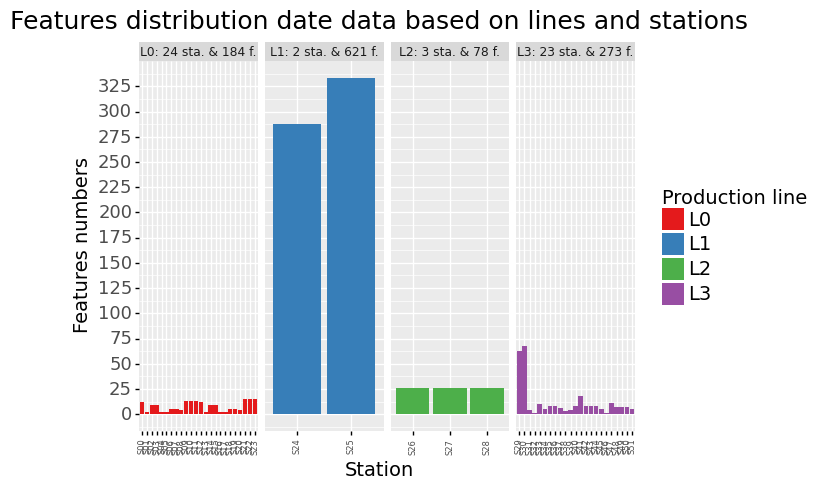

<ggplot: (-9223371868789522760)>

In [4]:
line_information = {'L0': "L0: 24 sta. & 184 f.",
                    'L1': "L1: 2 sta. & 621 f.",
                    'L2': "L2: 3 sta. & 78 f.",
                    'L3': "L3: 23 sta. & 273 f."}

g = u.draw_feature_distribution(features, line_information, 'date data')
ggsave(file="date_station_number.svg", plot = g, width=10, height=8, dpi = 500,format = 'svg')
g

In [ ]:
(tr, date_data) = u.load_agg_date_data(train_date, 2.4*10**5, 1.2*10**6)


In [262]:
(te, date_data) = u.load_agg_date_data(test_date, 2.4*10**5, 1.2*10**6)

c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
c:\py_venv\tutorial-venv\lib\site-packages\numpy\lib\nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
c:\py_venv\tutorial-venv\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
c:\py_venv\tutorial-venv\lib\site-packages\numpy\lib\nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered


In [4]:
tr = pd.read_csv('final features/date_agg_train.csv', index_col = 0) 
te = pd.read_csv('final features/date_agg_test.csv', index_col = 0)
le = pd.read_csv(train_numeric, usecols = ['Id', 'Response']) 

In [4]:
tr = pd.merge(tr, le, how = 'left', on = 'Id')
tr_te = pd.concat((tr, te), axis = 0).reset_index(drop=True).reset_index(drop=False)

In [6]:
# obtain the difference, last and next (.shift(1) or .shift(-1)) between each row
sorting = ['index', 'Id', ['All_min_date', 'Id'], ['All_max_date', 'Id'], 
          ['All_na_count', 'Id'], ['All_duration', 'Id']]

for s in sorting:
  
  col_name = ''.join(s)
  
  tr_te = tr_te.sort_values(by=s, ascending=True)
  
  tr_te[col_name+'_pre_id_diff'] = tr_te['Id'].diff().fillna(9999999).astype(int)
  tr_te[col_name+'_next_id_diff'] = tr_te['Id'].iloc[::-1].diff().fillna(9999999).astype(int)

  tr_te[col_name+'_pre_id'] = tr_te['Id'].shift(1).fillna(9999999).astype(int)
  tr_te[col_name+'_next_id'] = tr_te['Id'].shift(-1).fillna(9999999).astype(int)
  
  tr_te[col_name+'_pre_min_diff'] = tr_te['All_min_date'].diff().fillna(9999999).astype(int)
  tr_te[col_name+'_next_min_diff'] = tr_te['All_min_date'].iloc[::-1].diff().fillna(9999999).astype(int)

  tr_te[col_name+'_pre_min'] = tr_te['All_min_date'].shift(1).fillna(9999999).astype(int)
  tr_te[col_name+'_next_min'] = tr_te['All_min_date'].shift(-1).fillna(9999999).astype(int)
  
  tr_te[col_name+'_pre_max_diff'] = tr_te['All_max_date'].diff().fillna(9999999).astype(int)
  tr_te[col_name+'_next_max_diff'] = tr_te['All_max_date'].iloc[::-1].diff().fillna(9999999).astype(int)

  tr_te[col_name+'_pre_max'] = tr_te['All_max_date'].shift(1).fillna(9999999).astype(int)
  tr_te[col_name+'_next_max'] = tr_te['All_max_date'].shift(-1).fillna(9999999).astype(int)
  
  tr_te[col_name+'_pre_dur_diff'] = tr_te['All_duration'].diff().fillna(9999999).astype(int)
  tr_te[col_name+'_next_dur_diff'] = tr_te['All_duration'].iloc[::-1].diff().fillna(9999999).astype(int)
   
  tr_te[col_name+'_pre_dur'] = tr_te['All_duration'].shift(1).fillna(9999999).astype(int)
  tr_te[col_name+'_next_dur'] = tr_te['All_duration'].shift(-1).fillna(9999999).astype(int)
  
  if s != 'index':
    tr_te[col_name+'_pre_label'] = tr_te['Response'].shift(1).fillna(9999999).astype(int)
    tr_te[col_name+'next_label'] = tr_te['Response'].shift(-1).fillna(9999999).astype(int)

c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmen

In [7]:
sorts = [['All_min_date', 'Id'], ['All_min_date', 'All_max_date'], ['All_max_date', 'Id'], ['All_duration', 'Id'], 'Id']

windows = [3, 5, 7, 10, 100, 1000, 10000]

for sort in sorts:
  
  col_name = ''.join(sort)
  
  tr_te = tr_te.sort_values(by=sort, ascending=True)

  for window in windows:

    tr_te[col_name + '_pre_label_' + str(window)] = pd.Series(tr_te.sort_values(by=s, ascending=True)['Response']).rolling(window = window, min_periods=1).mean().shift(1)
    tr_te[col_name + '_next_label_' + str(window)] = pd.Series(tr_te.sort_values(by=s, ascending=True)['Response']).rolling(window = window, min_periods=1).mean().shift(1)[::-1]
    
    tr_te[col_name+'_pre_label_'+str(window)][0:window] = np.nan
    tr_te[col_name+'_next_label_'+str(window)][(tr_te.shape[0]-window):tr_te.shape[0]] = np.nan

c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\py_

In [9]:
tr_te = tr_te.drop(['Response'], axis=1)
tr_te = tr_te.sort_values(by=['index']).drop(['index'], axis=1)
tr_te = tr_te.fillna(9999999)

In [10]:
tr = tr_te.iloc[:1183747, :]
te = tr_te.iloc[1183747:, :]
print(tr.shape)
print(te.shape)

(1183747, 219)
(1183748, 219)


In [4]:
# tr.to_csv('date model/train_date_features.csv')
# te.to_csv('date model/test_date_features.csv')
# tr = pd.read_csv('date model/train_date_features.csv')
# te = pd.read_csv('date model/test_date_features.csv')

# Find feature importance

In [5]:
le = pd.read_csv(train_numeric, usecols = ['Response'])

In [ ]:
data = pd.concat([tr, le.drop(['Id'], axis = 1)], axis = 1)
print(data.shape)

In [14]:
X = data.drop(['Id', 'Response'], axis = 1)
y = data['Response']
print(X.shape)
print(y.shape)

(1183747, 218)
(1183747,)


In [25]:


def best_thr_mcc(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = np.linspace(0.30, 0.335, 3)
    mcc = np.array([matthews_corrcoef(labels, preds > thr)
                   for thr in thresholds])
    best_thr = thresholds[np.argmax(mcc)]
    best_score = mcc.max()
    return best_thr, best_score

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = np.linspace(0.30, 0.335, 3)
    mcc = np.array([matthews_corrcoef(labels, preds > thr)
                   for thr in thresholds])
    best_score = mcc.max()
    return 'error', -best_score

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
mcc_score = []
g_means_scores = []
f1_scores = []
thresh = []

num_round = 50
params = {'colsample_bytree':0.8, 
          'eta':0.1,
          'max_depth': 12,
          'subsample': 0.9,
          'min_child_weight': 15, 
          'objective': 'binary:logistic',
          'random_state': 71,
          'silent': 0
            }

for tr_idx, va_idx in kf.split(X, y):
    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, 
                      num_round, 
                      evals = watchlist, 
                      verbose_eval=True, 
                      early_stopping_rounds=10, 
                      feval = evalerror)
    
    va_pred = model.predict(dvalid)
    
    best_thresh, mcc_value= best_thr_mcc(va_pred, dvalid)
    y_pred = np.array([1 if y_pro > best_thresh else 0 for y_pro in va_pred])

    tn, fp, fn, tp = confusion_matrix(va_y, y_pred).ravel()
    spec = tn / (tn+fp)
    sens = tp / (tp + fn)
    g_means = np.sqrt(spec * sens)
    fmeasure = f1_score(va_y, y_pred)

    print('mcc value: {}'.format(mcc_value))
    print('g_means value: {}'.format(g_means))
    print('f1_score value: {}'.format(fmeasure))
    
    thresh.append(best_thresh)
    mcc_score.append(mcc_value)
    g_means_scores.append(g_means)
    f1_scores.append(fmeasure)

    
    gc.collect()

print('avg_MCC:', round(np.mean(mcc_score), 3))
print('avg_g_means:', round(np.mean(g_means_scores), 3))
print('avg_f1_score:', round(np.mean(f1_scores), 3))


[14:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.59974	train-error:-0.00000	eval-logloss:0.60008	eval-error:-0.00000
[1]	train-logloss:0.52323	train-error:-0.14366	eval-logloss:0.52363	eval-error:-0.14224
[2]	train-logloss:0.46004	train-error:-0.21155	eval-logloss:0.46007	eval-error:-0.17547
[3]	train-l

In [27]:
fscore = model.get_score(importance_type = 'total_gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))
feat_imp

,feature,scores,score
All_max_dateId_next_label100,All_max_dateId_next_label100,0.559326,0.000491
All_max_dateId_pre_label1000,All_max_dateId_pre_label1000,1.927250,0.001693
L2_std_date,L2_std_date,2.907223,0.002553
L0_unique_val,L0_unique_val,2.920382,0.002565
All_min_dateAll_max_date_pre_label3,All_min_dateAll_max_date_pre_label3,3.199181,0.002810
...,...,...,...
All_min_dateId_next_dur_diff,All_min_dateId_next_dur_diff,2526.926270,2.219169
All_durationId_next_id_diff,All_durationId_next_id_diff,3040.980713,2.670616
L3_na_count,L3_na_count,4472.502441,3.927792
All_na_countId_next_id_diff,All_na_countId_next_id_diff,4566.953613,4.010739


In [26]:
# model.save_model("date model/date_xgb_model.json")
# feat_imp.to_csv('date model/selected features 20.csv')

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371949455606256.svg


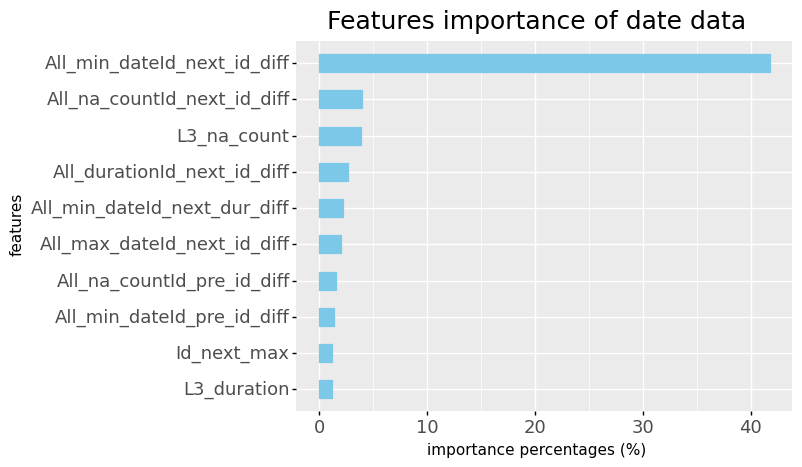

<ggplot: (-9223371949455606256)>

In [33]:
g = (
    ggplot(feat_imp.iloc[-10:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=13),
            plot_title=element_text(size=18))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of date data')
)
# ggsave(file="Features importance of date data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [9]:
data['Response'] = data['Response'].astype('category')

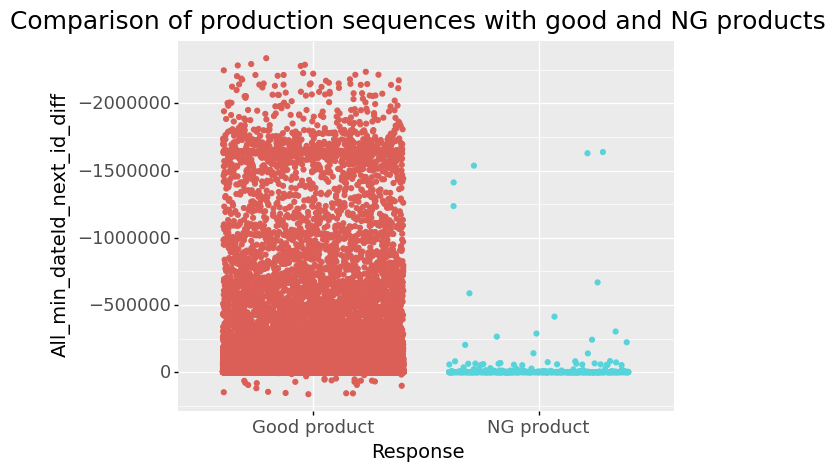

<ggplot: (-9223371949373918460)>

In [49]:
g = (
    ggplot(data.iloc[:100000, :], aes(x = 'Response', y = 'All_min_dateId_next_id_diff'))
    + geom_jitter(aes(colour = 'Response', fill = 'Response'))
    + scale_y_continuous(trans = "reverse")
    + scale_x_discrete(labels=["Good product", 'NG product'])
    + theme(axis_text_x=element_text(size=13),
            axis_text_y=element_text(size=13),
            axis_title=element_text(size=14),
            plot_title=element_text(size=18),
            legend_position = 'none')
    + ggtitle('Comparison of production sequences with good and NG products')
)
# ggsave(file="Comparison of production sequences with good and NG products.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [15]:
start = pd.read_csv('date model/train_date_features.csv', usecols = ['Id', 'All_min_dateId_next_id_diff'])
le = pd.read_csv('data/train_numeric.csv', usecols = ['Id', 'Response'])
start = pd.merge(start, le, how = 'left', on = 'Id')

In [10]:
start = data[['Id', 'All_min_dateId_next_id_diff', 'Response']]

In [23]:
start['Id difference <= 2'] = np.where(start['All_min_dateId_next_id_diff'] > -2, 1, 0)
start['Id difference <= 2'] = start['Id difference <= 2'].astype('category')
start['Response'] = start['Response'].astype('category')

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371954565221348.svg


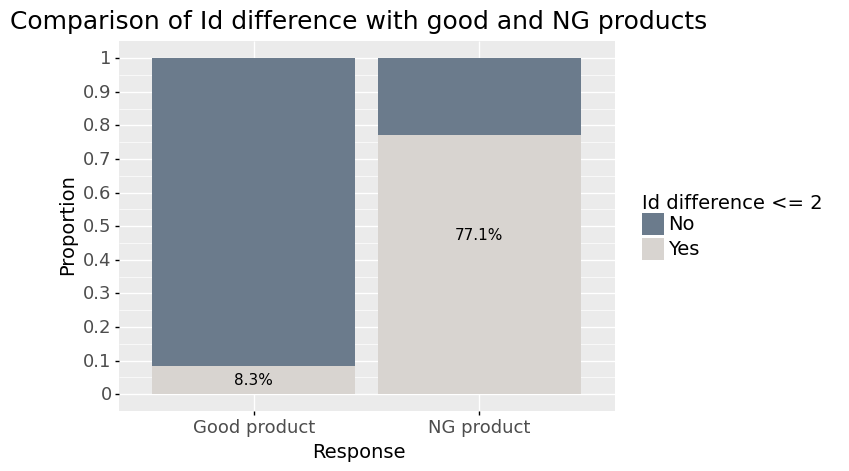

<ggplot: (-9223371954565221348)>

In [27]:
g = (
    ggplot(start, aes(x = 'Response', fill = 'Id difference <= 2'))
    + geom_bar(position = 'fill')
    + scale_y_continuous(breaks = np.linspace(0, 1, 11))
    + scale_x_discrete(labels=["Good product", 'NG product'])
    + theme(axis_text_x=element_text(size=13),
            axis_text_y=element_text(size=13),
            axis_title=element_text(size=14),
            plot_title=element_text(size=18),
            legend_text = element_text(size = 14),
            legend_title = element_text(size = 14)
    )
    + scale_fill_manual(values= ["#6b7b8c", "#D8D4D0"], labels = ['No', 'Yes'])
    + labs(y = 'Proportion')
    + annotate("text", x = 1, y = 0.045, label = "8.3%")
    + annotate("text", x = 2, y = 0.474, label = "77.1%")
    + ggtitle('Comparison of Id difference with good and NG products')

)
ggsave(file="Comparison of Id difference with good and NG products.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')

g

In [4]:
date_feat = load_date_date(train_date, 5*10**4, 5*10**4)

c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
c:\py_venv\tutorial-venv\lib\site-packages\numpy\lib\nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
c:\py_venv\tutorial-venv\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
